# Time Series Analysis with Polars: Exoplanet Transit Detection

In this beginner-friendly tutorial, we'll learn about **Polars**, a modern data manipulation library, by analyzing real astronomy data from NASA's TESS mission.

## Overview

### What You'll Learn
By the end of this tutorial, you'll be able to:
- Load and explore data using Polars' eager and lazy modes
- Write Polars expressions and chain operations together
- Understand when and why to use lazy evaluation
- Handle missing data and create derived columns
- Perform time series operations (rolling windows, binning, grouping)
- Compare Polars and pandas performance on real tasks
- Create both static and interactive visualizations

### Prerequisites
You should be comfortable with:
- **Python basics** (functions, loops, variables)
- **DataFrames concepts** (rows, columns, filtering, grouping)
- **Basic pandas** (if you've used `df[df['col'] > 5]`, you're good!)

You do NOT need:
- Deep pandas expertise
- Prior Polars experience
- Astronomy knowledge (we'll explain what you need!)

### What We'll Build
We'll analyze real NASA space telescope data to detect an exoplanet transit, learning Polars along the way. You'll end up with:
- A clean, analyzed dataset of astronomical observations
- Performance benchmarks showing Polars' speed advantages
- Interactive visualizations of an exoplanet passing in front of its star

### Tutorial Structure
1. **Loading Data** - Eager vs lazy evaluation
2. **Polars Syntax** - Expressions and selections
3. **Lazy Evaluation** - Query optimization in action
4. **Data Cleaning** - Real-world data wrangling
5. **Time Series** - Rolling stats and binning
6. **Performance** - Head-to-head with pandas
7. **Visualization** - Static and interactive plots 

## What are we analyzing?

We're looking at a **phase-folded light curve** from the exoplanet [WASP-18 b](https://en.wikipedia.org/wiki/WASP-18b). Here's what that means:
- When a planet passes in front of its star (called a **transit**), it blocks some of the star's light
- We observe this star over and over, catching many transits
- **Phase-folding** means we align all these observations by the planet's orbital period, stacking them together
- This makes the repeating transit signal much easier to see
- **Phase 0** represents the moment when the planet is directly in front of the star

## Why use Polars instead of pandas?

Both are excellent tools, but they shine in different situations:

**Use pandas when:**
- Your data fits easily in memory (under ~500MB)
- You're doing quick, exploratory analysis
- You need the massive pandas-compatible ecosystem

**Use Polars when:**
- You're working with larger datasets
- You're doing multi-step transformations that could benefit from optimization
- You want the fastest performance without extra configuration

In this tutorial, we'll see Polars' key strengths: **lazy evaluation**, **query optimization**, and **clean expression syntax**.

**Data source:** STScI MAST Archive (WASP-18 b, TIC 100100827)    
See `fetch_data.py` to see how our dataset was built and how to create your own dataset using a different exoplanet.

## Setup and Imports

Let's import the libraries we'll need.

In [ ]:
import polars as pl              # Our star of the show
import pandas as pd              # For comparison
import numpy as np               # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import pyarrow as pa             # For date handling
from bokeh.plotting import figure, output_notebook, show  # For interactive plots
from bokeh.models import HoverTool
import time                      # For timing our performance comparisons

# Set random seed so our results are reproducible
np.random.seed(42)

## 1. Loading Data: Your First Choice

Before you start working with data, Polars asks you to make a choice. This choice determines how Polars will handle your analysis.

### Two ways to load data:

1. **Eager mode** (`read_csv`): Loads data immediately into memory
   - Pro: Simple and familiar
   - Con: Executes operations immediately, no optimization

2. **Lazy mode** (`scan_csv`): Creates a query plan without loading data
   - Pro: Polars optimizes your entire workflow before running anything
   - Con: You need to remember to `.collect()` at the end

We'll start with **eager mode** to explore our data, then switch to **lazy mode** to see the optimization.

### Let's load our light curve data:

In [2]:
# Load the phase-folded light curve data
# This reads the entire CSV file into memory right now
df = pl.read_csv('wasp18b_lightcurve.csv')

# Check what we got
print(f"Dataset shape: {df.shape}")  # (rows, columns)
print(f"\nColumn names and types:")
print(df.schema)  # Polars automatically infers data types

Dataset shape: (37521, 3)

Column names and types:
Schema({'PHASE': Float64, 'LC_DETREND': Float64, 'MODEL_INIT': Float64})


**🌟 Learning note:** Notice that Polars shows us the `Schema` - this is Polars' way of showing column names and their data types. Polars is more strict about types than pandas, which helps catch errors early.

In [3]:
# Look at the first few rows
# This helps us understand what our data looks like
df.head(10)

PHASE,LC_DETREND,MODEL_INIT
f64,f64,f64
0.589409,null,0.0
0.590798,null,0.0
0.592187,null,0.0
0.593576,null,0.0
0.594965,null,0.0
0.596354,-0.000061,0.0
0.597743,-0.000863,0.0
0.599132,null,0.0
0.600521,-0.000617,0.0


### What do these columns mean?

- **PHASE**: Position in the orbit (days). 0 = planet in front of star
- **LC_DETREND**: The measured brightness change (as a fraction)
- **MODEL_INIT**: The fitted transit model for comparison

Notice some `null` values in `LC_DETREND`? That's normal with telescope data - we'll handle those later.

In [4]:
# Get summary statistics for each column
# This is like pandas' describe() but returns a Polars DataFrame
df.describe()

statistic,PHASE,LC_DETREND,MODEL_INIT
str,f64,f64,f64
"""count""",37521.0,31761.0,37521.0
"""null_count""",0.0,5760.0,0.0
"""mean""",0.234784,-0.000786,-0.000849
"""std""",0.272647,0.002838,0.002745
"""min""",-0.235322,-0.01254,-0.010693
"""25%""",-0.002413,-0.000478,0.0
"""50%""",0.234411,-0.000007,0.0
"""75%""",0.471332,0.000398,0.0
"""max""",0.70608,0.012784,0.0


**What to notice:** The `LC_DETREND` values are very small (around 0.0001). That's because they represent tiny changes in brightness. We'll convert these to **parts per million (ppm)** later to make them easier to read.

## 2. Polars Expressions: A Different Way of Thinking

Here's where Polars differs from pandas. Instead of modifying dataframes directly, you build **expressions** that describe what you want to do.

### Why expressions?
- They can be **optimized** before execution
- They're **explicit** about what data you're working with
- They **compose together** cleanly

### Let's compare pandas vs Polars syntax:

```python
# In pandas, you typically modify the dataframe in place:
df['flux_ppm'] = df['LC_DETREND'] * 1e6
result = df[['PHASE', 'flux_ppm']]

# In Polars, you use .select() with expressions:
result = df.select([
    pl.col('PHASE'),                          # Select the PHASE column
    (pl.col('LC_DETREND') * 1e6).alias('flux_ppm')  # Create a new column
])
```

The Polars version is more verbose, but it's also more explicit: `pl.col()` makes it clear we're working with columns.

In [5]:
# Let's create a new view of our data with a more readable flux column
# We're converting from fractional change to parts per million (ppm)
df_with_ppm = df.select([
    pl.col('PHASE'),                                    # Keep phase as-is
    pl.col('LC_DETREND'),                               # Keep original flux
    (pl.col('LC_DETREND') * 1e6).alias('flux_ppm'),    # Create new flux_ppm column
    pl.col('MODEL_INIT')                                # Keep the model
])

df_with_ppm.head(10)

PHASE,LC_DETREND,flux_ppm,MODEL_INIT
f64,f64,f64,f64
0.589409,null,null,0.0
0.590798,null,null,0.0
0.592187,null,null,0.0
0.593576,null,null,0.0
0.594965,null,null,0.0
0.596354,-0.000061,-61.42538,0.0
0.597743,-0.000863,-862.733228,0.0
0.599132,null,null,0.0
0.600521,-0.000617,-616.867852,0.0


**Now our flux is in ppm:** Much easier to read! Instead of -0.000863, we see -862.7 ppm. This means the star's brightness decreased by about 863 parts per million during that observation.

### Filtering Data with Polars

Let's zoom in on just the transit window (when the planet is in front of the star). 

In [6]:
# Filter to the transit window
# We're looking at phases between -0.05 and +0.05 days
# That's about 2.4 hours on either side of the transit center
transit_data = df_with_ppm.filter(
    (pl.col('PHASE') >= -0.05) & (pl.col('PHASE') <= 0.05)  # Both conditions must be true
)

print(f"Original data points: {len(df_with_ppm):,}")
print(f"Transit window data points: {len(transit_data):,}")
print(f"That's {100 * len(transit_data) / len(df_with_ppm):.1f}% of our data")
print(f"\nTransit window data:")
transit_data.head(10)

Original data points: 37,521
Transit window data points: 3,982
That's 10.6% of our data

Transit window data:


PHASE,LC_DETREND,flux_ppm,MODEL_INIT
f64,f64,f64,f64
-0.049253,-0.000512,-512.172235,0.0
-0.047864,0.000666,665.60728,0.0
-0.046475,-0.001035,-1035.455847,-0.000025
-0.045086,-0.000404,-404.070423,-0.000271
-0.043697,-0.001458,-1458.059298,-0.000894
-0.042308,-0.002087,-2087.299479,-0.001975
-0.040919,-0.004626,-4625.804722,-0.003465
-0.039531,-0.005095,-5094.776861,-0.00511
-0.038142,-0.007137,-7137.154695,-0.006607


**🌟 Key concept - Filtering:** The `&` symbol combines conditions (both must be true). Use `|` for "or" (either can be true). Notice we don't need `.query()` like in pandas - we just use `.filter()` directly!

## 3. Lazy Evaluation: Polars' Superpower

Now for the really cool part. Instead of running each operation immediately, we can build up a **query plan** and let Polars optimize it.

### How lazy evaluation works:
1. You use `.scan_csv()` instead of `.read_csv()`
2. You chain your operations together
3. Polars builds a plan but **doesn't execute anything yet**
4. You can look at the optimized plan with `.explain()`
5. You run everything at once with `.collect()`

### Why is this powerful?
- Polars can **reorder operations** for efficiency
- It can **push filters down** to reduce data early
- It only **selects columns you actually need**
- It can **parallelize** operations automatically

Let's see it in action:

In [7]:
# Create a lazy query - nothing executes yet!
lazy_query = (
    pl.scan_csv('wasp18b_lightcurve.csv')  # Step 1: Specify the file (not loaded yet!)
    .select([                               # Step 2: Which columns do we want?
        pl.col('PHASE'),
        pl.col('LC_DETREND'),
        (pl.col('LC_DETREND') * 1e6).alias('flux_ppm')
    ])
    .filter(pl.col('LC_DETREND').is_not_null())  # Step 3: Remove null values
    .filter(                                      # Step 4: Keep only transit window
        (pl.col('PHASE') >= -0.05) & (pl.col('PHASE') <= 0.05)
    )
    .sort('PHASE')                          # Step 5: Sort by phase
)

print("Query plan created!")
print("But NO data has been loaded or processed yet.")
print(f"\nType: {type(lazy_query)}")
print("This is a LazyFrame, not a DataFrame!")

Query plan created!
But NO data has been loaded or processed yet.

Type: <class 'polars.lazyframe.frame.LazyFrame'>
This is a LazyFrame, not a DataFrame!


### Examining the Query Plan

Before we run anything, let's peek at how Polars optimized our query. This is like looking at the recipe before you start cooking.

In [8]:
# Show the optimized query plan
print("Polars' Optimized Execution Plan:")
print("=" * 50)
print(lazy_query.explain())
print("=" * 50)

Polars' Optimized Execution Plan:
SORT BY [col("PHASE")]
  SELECT [col("PHASE"), col("LC_DETREND"), [(col("LC_DETREND")) * (1e6)].alias("flux_ppm")]
    Csv SCAN [wasp18b_lightcurve.csv]
    PROJECT 2/3 COLUMNS
    SELECTION: [(col("LC_DETREND").is_not_null()) & ([([(col("PHASE")) >= (-0.05)]) & ([(col("PHASE")) <= (0.05)])])]
    ESTIMATED ROWS: 37734


**Reading the plan (bottom to top):**

Notice how Polars optimized our query:

1. **Csv SCAN** - It knows which file to read
2. **PROJECT 2/3 COLUMNS** - It only reads the columns we need (PHASE and LC_DETREND), not all 3!
3. **SELECTION** - It pushes both filters down to the data source (reads less data)
4. **SELECT** - Creates our derived columns
5. **SORT** - Finally sorts the result

**This is optimization!** Polars figured out the most efficient order and avoided reading data we don't need.

In [ ]:
# Now let's actually execute the query
# This is where Polars loads the data and runs all operations
transit_clean = lazy_query.collect()  # .collect() triggers execution

print(f"Query executed!")
print(f"Result shape: {transit_clean.shape}")
transit_clean.head(10)

✓ Query executed!
Result shape: (3331, 3)


PHASE,LC_DETREND,flux_ppm
f64,f64,f64
-0.049945,-0.000658,-658.190111
-0.049939,-0.001068,-1068.430953
-0.049916,0.000529,529.020559
-0.049913,0.000488,488.216057
-0.049905,0.00063,630.485301
-0.04988,-0.001434,-1433.593687
-0.049872,-0.000676,-675.78099
-0.049812,-0.000376,-376.086944
-0.049739,-0.000756,-756.382593


**🌟 Pro tip:** Use lazy evaluation for any multi-step analysis. Build your whole pipeline, let Polars optimize it, then execute once with `.collect()`. This is especially powerful with large datasets!

## 4. Data Cleaning: Handling the Real World

Real data is messy! Our dataset has missing values (nulls) where the telescope couldn't make measurements. Let's handle them and add some useful features.

In [10]:
# First, let's see how many null values we have
null_counts = df.null_count()
print("Missing values per column:")
print(null_counts)

Missing values per column:
shape: (1, 3)
┌───────┬────────────┬────────────┐
│ PHASE ┆ LC_DETREND ┆ MODEL_INIT │
│ ---   ┆ ---        ┆ ---        │
│ u32   ┆ u32        ┆ u32        │
╞═══════╪════════════╪════════════╡
│ 0     ┆ 5760       ┆ 0          │
└───────┴────────────┴────────────┘


**Understanding nulls:** We have 5,760 missing values in LC_DETREND (about 15% of our data). This happens when:
- The telescope was pointed elsewhere
- Data was flagged as poor quality
- There's interference with the detector

For our analysis, we'll simply remove these rows. In a real scientific analysis, you'd want to investigate why they're missing.

### Method Chaining: Building Pipelines

One of Polars' best features is **method chaining** - connecting operations together. Let's clean our data and add useful columns all in one go:

In [11]:
# Clean and enhance our dataset in one pipeline
df_clean = (
    df
    # Step 1: Remove rows where flux is null
    .filter(pl.col('LC_DETREND').is_not_null())
    
    # Step 2: Add three new useful columns
    .with_columns([
        # Convert flux to parts per million (easier to read)
        (pl.col('LC_DETREND') * 1e6).alias('flux_ppm'),
        
        # Calculate absolute distance from transit center
        # This helps us filter by "how close to transit"
        pl.col('PHASE').abs().alias('abs_phase'),
        
        # Create a boolean flag: True if this point is during transit
        # We define "during transit" as within 0.05 days of phase 0
        ((pl.col('PHASE') >= -0.05) & (pl.col('PHASE') <= 0.05)).alias('in_transit')
    ])
    
    # Step 3: Sort by phase for easier analysis
    .sort('PHASE')
)

# Show what we did
print(f"Original data: {len(df):,} points")
print(f"Clean data: {len(df_clean):,} points")
print(f"Removed: {len(df) - len(df_clean):,} null values")
print(f"\nOur cleaned dataset now has {len(df_clean.columns)} columns:")
print(df_clean.columns)
print(f"\nFirst few rows:")
df_clean.head()

Original data: 37,521 points
Clean data: 31,761 points
Removed: 5,760 null values

Our cleaned dataset now has 6 columns:
['PHASE', 'LC_DETREND', 'MODEL_INIT', 'flux_ppm', 'abs_phase', 'in_transit']

First few rows:


PHASE,LC_DETREND,MODEL_INIT,flux_ppm,abs_phase,in_transit
f64,f64,f64,f64,f64,bool
-0.235322,0.000716,0.0,715.785776,0.235322,false
-0.235309,0.000958,0.0,957.731449,0.235309,false
-0.235289,-0.000312,0.0,-311.740499,0.235289,false
-0.235283,0.000632,0.0,631.729199,0.235283,false
-0.235283,0.000302,0.0,302.377448,0.235283,false


**Method chaining explained:**
- Each method returns a new DataFrame/LazyFrame
- We connect them with `.` (the dot operator)
- Read from top to bottom to understand the pipeline
- This is similar to pandas, but Polars can optimize the entire chain when using lazy mode!

**New columns we created:**
- `flux_ppm`: The brightness change in parts per million (easier to interpret)
- `abs_phase`: Absolute distance from transit center (useful for filtering)
- `in_transit`: Boolean flag marking transit observations

### Comparing with pandas

Let's see how this looks in pandas vs Polars:

```python
# Pandas approach (executes each step immediately)
df_pandas = (
    df_pandas
    .dropna(subset=['LC_DETREND'])                     # Remove nulls
    .assign(flux_ppm=lambda x: x['LC_DETREND'] * 1e6) # Add column
    .sort_values('PHASE')                              # Sort
)

# Polars approach (can be optimized with .lazy())
df_polars = (
    pl.scan_csv('data.csv')                            # Start lazy
    .filter(pl.col('LC_DETREND').is_not_null())       # Remove nulls
    .with_columns([                                    # Add columns
        (pl.col('LC_DETREND') * 1e6).alias('flux_ppm')
    ])
    .sort('PHASE')                                     # Sort
    .collect()                                         # Execute optimized plan
)
```

**🌟 Key difference:** pandas executes each step as you go. Polars (in lazy mode) optimizes the entire pipeline first.

## 5. Time Series Operations

Now let's do some analysis! We'll calculate rolling statistics and bin our data to reduce noise.

### Rolling Statistics: Smoothing the Data

**Rolling windows** help us smooth noisy data and estimate uncertainty. We'll calculate a rolling mean and standard deviation over 50 data points.

In [12]:
# Calculate rolling statistics using a 50-point window
# This means for each point, we average it with the 49 points before it
df_with_rolling = df_clean.with_columns([
    # Rolling mean: smooths out the noise
    pl.col('flux_ppm').rolling_mean(window_size=50).alias('flux_ppm_smooth'),
    
    # Rolling standard deviation: shows us the scatter/noise level
    pl.col('flux_ppm').rolling_std(window_size=50).alias('flux_ppm_std')
])

# Look at just the transit region
transit_region = df_with_rolling.filter(
    (pl.col('PHASE') >= -0.02) & (pl.col('PHASE') <= 0.02)  # Zoom in close
)

print(f"Transit region: {len(transit_region)} points")
print("\nNotice the new smoothed columns:")
transit_region.head(10)

Transit region: 1308 points

Notice the new smoothed columns:


PHASE,LC_DETREND,MODEL_INIT,flux_ppm,abs_phase,in_transit,flux_ppm_smooth,flux_ppm_std
f64,f64,f64,f64,f64,bool,f64,f64
-0.019945,-0.010017,-0.010241,-10017.435998,0.019945,true,-10224.874113,1872.884654
-0.019841,-0.011437,-0.010246,-11436.942033,0.019841,true,-10245.232172,1880.554822
-0.019822,-0.011226,-0.010247,-11226.323433,0.019822,true,-10236.828756,1875.096238
-0.019804,-0.010563,-0.010248,-10562.556796,0.019804,true,-10232.964437,1874.203823
-0.019788,-0.010439,-0.010249,-10439.142585,0.019788,true,-10239.231698,1874.362016
-0.019775,-0.01111,-0.010249,-11109.585874,0.019775,true,-10244.871397,1876.591369
-0.019769,-0.0106,-0.01025,-10600.29678,0.019769,true,-10266.428851,1874.312522
-0.019754,-0.010258,-0.01025,-10257.832706,0.019754,true,-10256.946031,1873.108133
-0.019749,-0.011322,-0.01025,-11321.502738,0.019749,true,-10258.777644,1874.123472


**What rolling windows tell us:**
- `flux_ppm_smooth`: The smoothed light curve (easier to see the transit shape)
- `flux_ppm_std`: The noise level at each point

**Window size matters:**    
Larger windows = smoother but you might miss small features.    
Smaller windows = noisier but more detail.

### Binning Data: Reducing Noise

Another way to reduce noise is **binning**: we group nearby points and average them. This is great for visualization!

In [13]:
# Create bins and calculate mean flux in each bin
# We're making bins that are 0.01 days wide (about 14 minutes)
df_binned = (
    df_clean
    # Step 1: Create bin labels
    # Multiply phase by 100 and round: turns 0.0123 into 1.0, and 0.0189 into 2.0
    .with_columns([
        (pl.col('PHASE') * 100).round(0).alias('phase_bin')
    ])
    
    # Step 2: Group by bin and calculate statistics
    .group_by('phase_bin')
    .agg([
        pl.col('PHASE').mean().alias('phase_mean'),       # Average phase in this bin
        pl.col('flux_ppm').mean().alias('flux_ppm_mean'), # Average flux in this bin
        pl.col('flux_ppm').std().alias('flux_ppm_std'),   # Scatter in this bin
        pl.col('flux_ppm').count().alias('n_points')      # How many points in this bin
    ])
    
    # Step 3: Sort by phase
    .sort('phase_mean')
)

print(f"Original dataset: {len(df_clean):,} data points")
print(f"Binned dataset: {len(df_binned)} bins")
print(f"That's a {len(df_clean) / len(df_binned):.0f}x reduction!")
print(f"\nEach bin contains about {df_clean['flux_ppm'].count() / len(df_binned):.0f} points on average")
df_binned.head(10)

Original dataset: 31,761 data points
Binned dataset: 96 bins
That's a 331x reduction!

Each bin contains about 331 points on average


phase_bin,phase_mean,flux_ppm_mean,flux_ppm_std,n_points
f64,f64,f64,f64,u32
-24.0,-0.23517,181.614097,471.180929,13
-23.0,-0.230017,212.338,537.779268,333
-22.0,-0.220056,227.409755,565.899667,333
-21.0,-0.210004,176.03398,562.401769,334
-20.0,-0.199973,185.138078,523.007193,334
-19.0,-0.189962,180.758628,538.018514,330
-18.0,-0.180002,166.300988,540.612459,336
-17.0,-0.170023,131.674319,531.035431,342
-16.0,-0.160022,128.491444,557.59641,342


**Why bin data?**
- **Reduces noise:** Averaging many points together reduces random scatter
- **Clearer visualization:** Makes plots easier to read
- **Faster to work with:** 96 bins vs 31,761 points

The `group_by().agg()` pattern is powerful and you can use it whenever you want to summarize groups of data.

### Computing Transit Properties

Let's measure how deep the transit is. This tells us how big the planet is relative to its star!

In [14]:
# Calculate statistics comparing in-transit vs out-of-transit flux
transit_stats = df_clean.select([
    # Mean flux during transit (using our in_transit flag)
    pl.col('flux_ppm').filter(pl.col('in_transit')).mean().alias('mean_transit_flux'),
    
    # Minimum flux during transit (the deepest point)
    pl.col('flux_ppm').filter(pl.col('in_transit')).min().alias('min_transit_flux'),
    
    # Mean flux outside transit (the baseline)
    # .not_() inverts the boolean: True becomes False, False becomes True
    pl.col('flux_ppm').filter(pl.col('in_transit').not_()).mean().alias('mean_baseline_flux')
])

# Extract the values (they're in a 1-row DataFrame)
mean_transit = transit_stats['mean_transit_flux'][0]
min_transit = transit_stats['min_transit_flux'][0]
baseline = transit_stats['mean_baseline_flux'][0]

# Calculate transit depth
transit_depth = baseline - min_transit

print(f"Transit Statistics:")
print(f"  Baseline flux: {baseline:.1f} ppm")
print(f"  Mean in-transit flux: {mean_transit:.1f} ppm")
print(f"  Minimum flux: {min_transit:.1f} ppm")
print(f"  Transit depth: {transit_depth:.1f} ppm ({transit_depth/1e4:.2f}%)")
print(f"\nInterpretation: The planet blocks ~{transit_depth/1e4:.2f}% of the star's light!")

Transit Statistics:
  Baseline flux: 63.8 ppm
  Mean in-transit flux: -8038.7 ppm
  Minimum flux: -12539.6 ppm
  Transit depth: 12603.4 ppm (1.26%)

Interpretation: The planet blocks ~1.26% of the star's light!


## 6. Performance Comparison: Polars vs Pandas

Now for a speed test. We'll create a larger dataset and time a complex operation in both libraries.

### Setting up the comparison

To make the performance difference visible, we'll repeat our dataset 10 times. This simulates having a larger observational campaign.

In [15]:
# Create a larger dataset by repeating our data 10 times
# This simulates having more observations
df_large_polars = pl.concat([df_clean] * 10)
df_large_pandas = pd.concat([df_clean.to_pandas()] * 10, ignore_index=True)

print(f"Large dataset size: {len(df_large_polars):,} rows")
print(f"\nMemory usage:")
print(f"  Polars: {df_large_polars.estimated_size() / 1024 / 1024:.2f} MB")
print(f"  Pandas: {df_large_pandas.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
print(f"\nNote: Polars uses slightly less memory")

Large dataset size: 317,610 rows

Memory usage:
  Polars: 12.15 MB
  Pandas: 12.42 MB

Note: Polars uses slightly less memory


### The performance test

We'll do a complex operation that combines:
1. Filtering
2. Creating new columns
3. Grouping and aggregating
4. Sorting

This is the kind of multi-step analysis where Polars really shines!

In [16]:
# Complex operation: filter, transform, group, and aggregate
# We'll time all three approaches

# ========================================
# Polars (eager mode) - runs immediately
# ========================================
start = time.time()
result_polars_eager = (
    df_large_polars
    .filter(pl.col('abs_phase') < 0.3)  # Keep points near transit
    .with_columns([
        (pl.col('flux_ppm') ** 2).alias('flux_squared'),  # Square the flux
        (pl.col('PHASE') * 100).round(0).alias('phase_bin')  # Create bins
    ])
    .group_by('phase_bin')  # Group by bin
    .agg([  # Calculate statistics for each bin
        pl.col('PHASE').mean().alias('phase_mean'),
        pl.col('flux_ppm').mean().alias('flux_ppm_mean'),
        pl.col('flux_squared').mean().alias('flux_squared_mean'),
        pl.col('flux_ppm').count().alias('n_points')
    ])
    .sort('phase_mean')  # Sort by phase
)
time_polars_eager = time.time() - start

# ========================================
# Polars (lazy mode) - optimizes first
# ========================================
start = time.time()
result_polars_lazy = (
    df_large_polars
    .lazy()  # ← Switch to lazy mode
    .filter(pl.col('abs_phase') < 0.3)
    .with_columns([
        (pl.col('flux_ppm') ** 2).alias('flux_squared'),
        (pl.col('PHASE') * 100).round(0).alias('phase_bin')
    ])
    .group_by('phase_bin')
    .agg([
        pl.col('PHASE').mean().alias('phase_mean'),
        pl.col('flux_ppm').mean().alias('flux_ppm_mean'),
        pl.col('flux_squared').mean().alias('flux_squared_mean'),
        pl.col('flux_ppm').count().alias('n_points')
    ])
    .sort('phase_mean')
    .collect()  # ← Execute the optimized plan
)
time_polars_lazy = time.time() - start

# ========================================
# Pandas - for comparison
# ========================================
start = time.time()
result_pandas = (
    df_large_pandas
    .query('abs_phase < 0.3')  # Filter
    .assign(  # Create new columns
        flux_squared=lambda x: x['flux_ppm'] ** 2,
        phase_bin=lambda x: (x['PHASE'] * 100).round(0)
    )
    .groupby('phase_bin', as_index=False)  # Group
    .agg({  # Aggregate
        'PHASE': 'mean',
        'flux_ppm': 'mean',
        'flux_squared': 'mean'
    })
)
time_pandas = time.time() - start

# ========================================
# Show the results
# ========================================
print(f"\nPerformance Comparison:")
print(f"=" * 50)
print(f"  Polars (eager): {time_polars_eager:.3f} seconds")
print(f"  Polars (lazy):  {time_polars_lazy:.3f} seconds")
print(f"  Pandas:         {time_pandas:.3f} seconds")
print(f"=" * 50)
print(f"\nSpeedup:")
print(f"  Polars eager vs Pandas: {time_pandas / time_polars_eager:.1f}x faster")
print(f"  Polars lazy vs Pandas:  {time_pandas / time_polars_lazy:.1f}x faster")


Performance Comparison:
  Polars (eager): 0.004 seconds
  Polars (lazy):  0.003 seconds
  Pandas:         0.009 seconds

Speedup:
  Polars eager vs Pandas: 2.4x faster
  Polars lazy vs Pandas:  3.4x faster


**🌟 Key takeaway:** Polars' lazy evaluation provides the best performance by optimizing the entire query plan before execution. Even eager mode is typically faster than pandas.

**When does this matter?**
- Datasets > 500MB
- Complex multi-step transformations
- When you're running the same analysis repeatedly
- When you want maximum performance without manual optimization

## 7. Visualization

Let's see what we our results! We'll create both static plots (with matplotlib) and interactive plots (with Bokeh).

### Static Plots with Matplotlib

First, let's create a standard scientific plot showing the full light curve and a zoomed-in transit view.

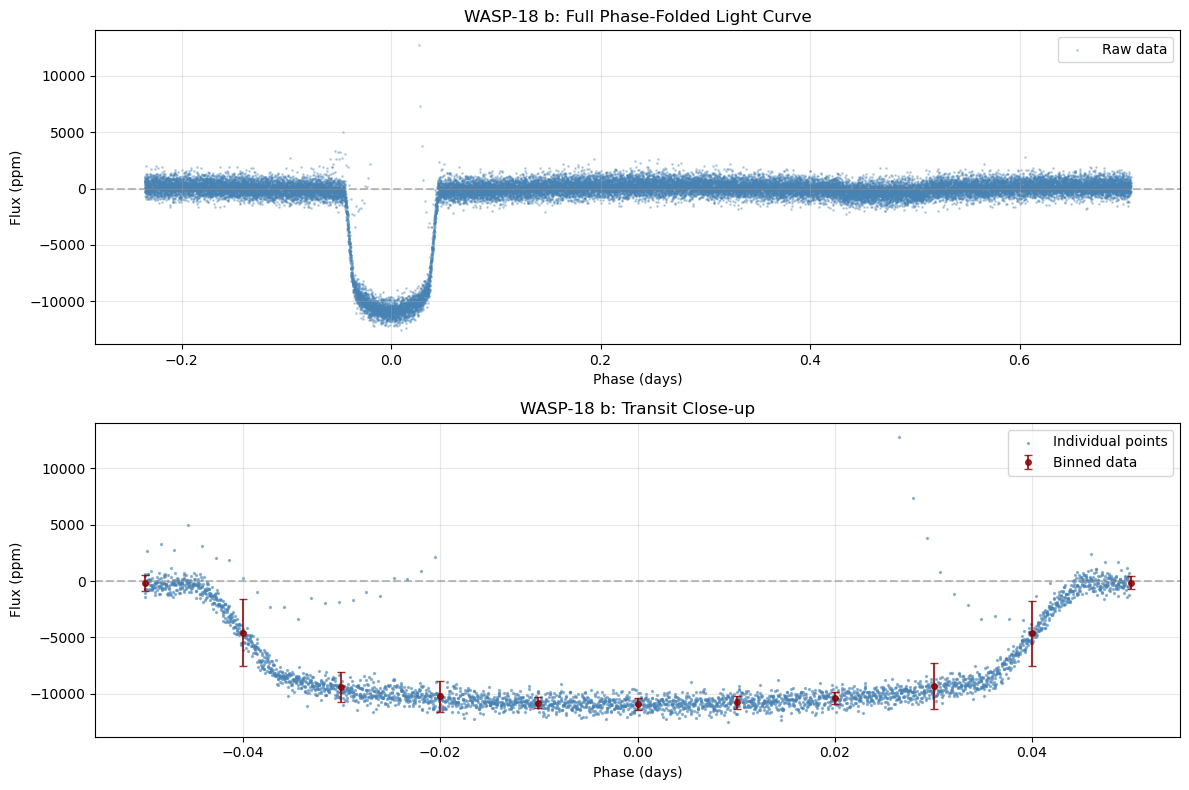

In [21]:
# Create a two-panel plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Convert to pandas for plotting (matplotlib works with pandas)
df_clean_pd = df_clean.to_pandas()

# ========================================
# Top panel: Full phase-folded light curve
# ========================================
ax1.scatter(df_clean_pd['PHASE'], df_clean_pd['flux_ppm'], 
            s=1, alpha=0.3, c='steelblue', label='Raw data')
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)  # Reference line
ax1.set_xlabel('Phase (days)')
ax1.set_ylabel('Flux (ppm)')
ax1.set_title('WASP-18 b: Full Phase-Folded Light Curve')
ax1.legend()
ax1.grid(True, alpha=0.3)

# ========================================
# Bottom panel: Zoomed to transit
# ========================================
transit_only = df_clean.filter(pl.col('in_transit')).to_pandas()

# Plot individual points
ax2.scatter(transit_only['PHASE'], transit_only['flux_ppm'], 
            s=2, alpha=0.5, c='steelblue', label='Individual points')

# Add binned data with error bars
binned_transit = df_binned.filter(
    (pl.col('phase_mean') >= -0.05) & (pl.col('phase_mean') <= 0.05)
).to_pandas()
ax2.errorbar(binned_transit['phase_mean'], binned_transit['flux_ppm_mean'],
             yerr=binned_transit['flux_ppm_std'],  # Error bars show scatter
             fmt='o', color='darkred', markersize=4, 
             capsize=3, alpha=0.8, label='Binned data')

ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Phase (days)')
ax2.set_ylabel('Flux (ppm)')
ax2.set_title('WASP-18 b: Transit Close-up')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**What do you see?**
- Top: The full orbit with the transit dip clearly visible
- Bottom: The U-shaped transit profile (this is the planet passing in front!)

### Interactive Bokeh Visualization

Now let's make an interactive plot where you can zoom and pan and hover over points to see their values.

We'll use [Bokeh](https://bokeh.org/), an Anaconda-supported, open source package that creates beautiful interactive visualizations great for exploring data like this.

In [18]:
# Enable Bokeh in Jupyter notebooks
output_notebook()

Loading BokehJS ...

In [22]:
# Prepare data for Bokeh (convert to pandas)
plot_data = df_clean.filter(pl.col('in_transit')).to_pandas()

# Create an interactive Bokeh figure
p = figure(
    width=900,
    height=500,
    title='WASP-18 b Transit (Interactive - Try zooming!)',
    x_axis_label='Phase (days)',
    y_axis_label='Flux (ppm)',
    tools='pan,wheel_zoom,box_zoom,reset,save'  # Interactive tools
)

# Add the scatter plot
scatter = p.scatter(
    x='PHASE',
    y='flux_ppm',
    source=plot_data,
    size=3,
    color='steelblue',
    alpha=0.5,
    legend_label='TESS observations'
)

# Add hover tool - shows values when you mouse over points
hover = HoverTool(
    tooltips=[
        ('Phase', '@PHASE{0.0000} days'),  # {0.0000} formats to 4 decimal places
        ('Flux', '@flux_ppm{0.0} ppm')     # {0.0} formats to 1 decimal place
    ],
    renderers=[scatter]
)
p.add_tools(hover)

# Add a reference line at y=0
p.line([-0.05, 0.05], [0, 0], line_width=2, color='gray',
       line_dash='dashed', alpha=0.5, legend_label='Baseline')

# Style the legend
p.legend.location = 'top_right'
p.legend.click_policy = 'hide'  # Click legend items to hide/show

# Display the plot
show(p)


**Interactive features:**
- Hover over points to see values
- Use mouse wheel to zoom
- Click and drag to pan
- Click legend items to hide/show data

### Full Light Curve with Binned Overlay

For our final plot, let's show both the raw data and binned data together across the full phase range.

In [23]:
# Prepare data
full_data = df_clean.to_pandas()
binned_data = df_binned.to_pandas()

# Create comprehensive interactive plot
p_full = figure(
    width=1000,
    height=400,
    title='WASP-18 b: Complete Phase-Folded Light Curve',
    x_axis_label='Phase (days)',
    y_axis_label='Flux (ppm)',
    tools='pan,wheel_zoom,box_zoom,reset,save'
)

# Raw data points (light color, transparent)
raw_scatter = p_full.scatter(
    x='PHASE',
    y='flux_ppm',
    source=full_data,
    size=2,
    color='lightblue',
    alpha=0.3,
    legend_label='Raw observations'
)

# Binned data (dark color, opaque)
binned_scatter = p_full.scatter(
    x='phase_mean',
    y='flux_ppm_mean',
    source=binned_data,
    size=5,
    color='darkred',
    alpha=0.8,
    legend_label='Binned data'
)

# Add detailed hover for binned data
hover_binned = HoverTool(
    tooltips=[
        ('Phase', '@phase_mean{0.000} days'),
        ('Flux', '@flux_ppm_mean{0.0} ppm'),
        ('Std Dev', '@flux_ppm_std{0.0} ppm'),
        ('N points', '@n_points')
    ],
    renderers=[binned_scatter]
)
p_full.add_tools(hover_binned)

# Reference line
p_full.line([-0.25, 0.75], [0, 0], line_width=2, color='gray',
            line_dash='dashed', alpha=0.5)

# Style
p_full.legend.location = 'top_right'
p_full.legend.click_policy = 'hide'

show(p_full)

**This plot shows:**
- Light blue: All individual measurements (noisy but complete)
- Dark red: Binned averages (clearer signal, less noise)
- The transit is clearly visible as a sharp dip at phase 0

## Summary: When to Use Polars

You've now seen Polars in action! Let's recap when you should reach for Polars vs pandas.

### 🐻‍❄️ Polars excels when:

- Larger datasets (>500MB) where performance matters
- Multi-step transformations that benefit from query optimization
- You want maximum performance and can leverage lazy evaluation
- You need built-in parallelization without extra configuration
- You're doing production data pipelines where efficiency is critical

### 🐼 Pandas remains great for:

- Smaller datasets where optimization overhead isn't worth it
- Quick exploratory analysis and interactive work
- When you need the extensive pandas ecosystem (scikit-learn, etc.)
- Simple operations where performance difference is negligible
- When your team already has pandas expertise and the code works fine

### 🌟 Key Polars concepts we covered:

1. **Expression-based API**: Operations are expressions that compose and optimize together
2. **Lazy evaluation**: Build query plans that Polars optimizes before execution
3. **Method chaining**: Natural workflow for multi-step transformations
4. **Performance**: Significant speedups (2-10x) for complex operations

Both tools have their place in your data science toolkit. Learn Polars to level up your performance when the task calls for it!

## Learn More

- Polars Documentation: https://pola-rs.github.io/polars/
- GitHub Repository: https://github.com/pola-rs/polars
- STScI MAST Notebook Repository: https://spacetelescope.github.io/mast_notebooks/intro.html
- WASP-18 b: https://exo.mast.stsci.edu/exomast_planet.html?planet=WASP-18b

## Acknowledgements

- Built with Polars, pandas, matplotlib, Bokeh
- Data fetch and plotting adapted from STScI Archive Scientist Susan Mullally's [Exoplanet Data and TESS Light Curves Using Python Requests](https://spacetelescope.github.io/mast_notebooks/notebooks/TESS/beginner_tess_exomast/beginner_tess_exomast.html)
- Tutorial developed for the Anaconda community